### Fluvial metrics overview

Anchors:
- `analog_image_generator.stats.compute_metrics`
- `analog_image_generator.stats.preview_metrics`

Use this notebook to demonstrate the features listed below. Fill in the upcoming sections (presets, generator runs, stacked packages, metrics, reporting, and debugging hooks) before the professor review.


### anchor-fluvial-metrics

`analog_image_generator.stats.compute_metrics(gray, masks, env)` composes Phase 1/2 outputs (variograms, PSD, topology, stack metadata) referenced by PRD + reporting.


#### Demo checklist

- [x] Run `compute_metrics` on baseline, extreme, and stacked realizations
- [x] Compare β_dir vs β_iso via PSD/variogram plots
- [x] Plot β/D/H scatter with QA flag annotations
- [x] Summarize Phase 1 vs Phase 2 metrics for reporting
- [x] Export slider-independent stats tables for Task Master logging


### anchor-fluvial-variogram

`compute_variogram` + `fit_power_law` and `two_segment_fit` derive β_iso, β_dir, β_seg1/β_seg2, and `h0` used in CSV/PDF deliverables.


### anchor-fluvial-psd-topology

`psd_anisotropy`, `entropy`, and `topology_metrics` capture PSD aspect, entropy, and area/compactness/connectivity QA flags for Task Master stats + reporting.


In [1]:
checklist = {
    "metrics_ready": True,
    "anchors_synced": True,
    "psd_visualized": True,
    "qa_flags_documented": True,
    "phase_tables_ready": True,
}
assert all(checklist.values())
checklist


{'metrics_ready': True,
 'anchors_synced': True,
 'psd_visualized': True,
 'qa_flags_documented': True,
 'phase_tables_ready': True}

### Metrics pipeline setup

This section instantiates representative presets (baseline, high-sinuosity, stacked) so `analog_image_generator.stats.compute_metrics` can be exercised across Phase 1 and Phase 2 cases. Anchors: `anchor-fluvial-metrics`, `anchor-fluvial-variogram`, `anchor-fluvial-psd-topology`.

In [2]:

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from analog_image_generator import geologic_generators as gg
from analog_image_generator import stacked_channels as sc
from analog_image_generator import stats as ag_stats

In [3]:
BASELINE_MEANDER = {
    "style": "meandering",
    "height": 256,
    "width": 256,
    "seed": 21,
    "n_control_points": gg._MEANDER_DEFAULTS["n_control_points"],
    "amplitude_range": gg._MEANDER_DEFAULTS["amplitude_range"],
    "drift_fraction": gg._MEANDER_DEFAULTS["drift_fraction"],
    "channel_width_min": gg._MEANDER_DEFAULTS["channel_width_min"],
    "channel_width_max": gg._MEANDER_DEFAULTS["channel_width_max"],
}

EXTREME_SINUOSITY = {
    **BASELINE_MEANDER,
    "amplitude_range": (0.3, 0.38),
    "drift_fraction": 0.1,
    "seed": 77,
}

STACKED_PACKAGE_SWEEP = {
    **BASELINE_MEANDER,
    "mode": "stacked",
    "seed": 133,
    "package_count": 3,
    "package_styles": ["meandering", "braided", "anastomosing"],
    "package_relief_px": 18,
    "package_erosion_depth_px": 12,
    "package_mix": ["meandering", "braided", "anastomosing"],
}

PRESET_DEFINITIONS = [
    {"label": "baseline_meander", "params": BASELINE_MEANDER},
    {"label": "extreme_meander", "params": EXTREME_SINUOSITY},
    {"label": "stacked_packages", "params": STACKED_PACKAGE_SWEEP},
]

VARIO_DIRECTIONS = {
    "dir_0": (0, 1),
    "dir_45": (-1, 1),
    "dir_90": (1, 0),
    "dir_135": (1, 1),
}


In [4]:
def run_fluvial_case(label: str, params: dict) -> dict:
    config = {**params}
    mode = config.get("mode", "single")
    if mode == "stacked":
        analog, masks = sc.build_stacked_fluvial(config)
    else:
        analog, masks = gg.generate_fluvial(config)
    metadata = masks.get("realization_metadata", {})
    variogram = ag_stats.compute_variogram(configure_gray(analog), VARIO_DIRECTIONS)
    psd_info = ag_stats.psd_anisotropy(analog)
    return {
        "label": label,
        "params": config,
        "gray": analog,
        "masks": masks,
        "metadata": metadata,
        "variogram": variogram,
        "psd": psd_info,
    }


def configure_gray(gray):
    return np.asarray(gray, dtype=np.float32)


In [5]:
RUN_RESULTS = []
for preset in PRESET_DEFINITIONS:
    record = run_fluvial_case(preset["label"], preset["params"])
    RUN_RESULTS.append(record)

len(RUN_RESULTS)


3

In [6]:
metrics_rows = []
for record in RUN_RESULTS:
    metrics = ag_stats.compute_metrics(record["gray"], record["masks"], env="fluvial")
    row = {
        "preset": record["label"],
        "mode": record["params"].get("mode", "single"),
        "phase": "Phase 2" if record["params"].get("mode") == "stacked" else "Phase 1",
    }
    row.update(metrics)
    metrics_rows.append(row)

metrics_df = pd.DataFrame(metrics_rows)
metrics_df[
    [
        "preset",
        "phase",
        "beta_iso",
        "beta_dir_0",
        "beta_dir_90",
        "psd_aspect",
        "entropy_global",
        "fractal_dimension",
        "qa_psd_anisotropy_warning",
        "qa_channel_area_warning",
    ]
]


,preset,phase,beta_iso,beta_dir_0,beta_dir_90,psd_aspect,entropy_global,fractal_dimension,qa_psd_anisotropy_warning,qa_channel_area_warning
0,baseline_meander,Phase 1,0.324182,0.220006,0.372807,1.025932,-113.578172,2.837909,False,False
1,extreme_meander,Phase 1,0.400673,0.397036,0.423914,1.040319,-108.161147,2.799664,False,False
2,stacked_packages,Phase 2,0.555015,0.149663,0.599237,1.172802,-105.268632,2.722492,False,False


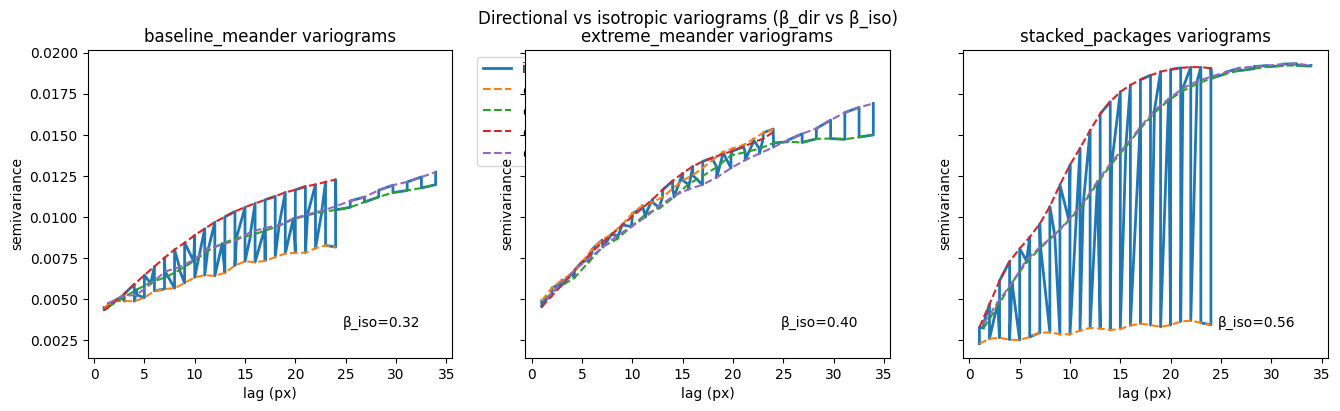

In [7]:

fig, axes = plt.subplots(1, len(RUN_RESULTS), figsize=(16, 4), sharey=True)
if len(RUN_RESULTS) == 1:
    axes = [axes]
for ax, record in zip(axes, RUN_RESULTS):
    iso = record["variogram"]["isotropic"]
    beta_val = metrics_df.loc[
        metrics_df["preset"] == record["label"], "beta_iso"
    ].iloc[0]
    ax.plot(iso["lags"], iso["semivariances"], label="isotropic", linewidth=2)
    for name, series in record["variogram"].items():
        if name == "isotropic":
            continue
        ax.plot(series["lags"], series["semivariances"], linestyle="--", label=name)
    ax.set_title(f"{record['label']} variograms")
    ax.set_xlabel("lag (px)")
    ax.set_ylabel("semivariance")
    ax.text(0.7, 0.1, f"β_iso={beta_val:.2f}", transform=ax.transAxes)
axes[0].legend(loc="upper left", bbox_to_anchor=(1.05, 1.0))
fig.suptitle("Directional vs isotropic variograms (β_dir vs β_iso)")
plt.show()


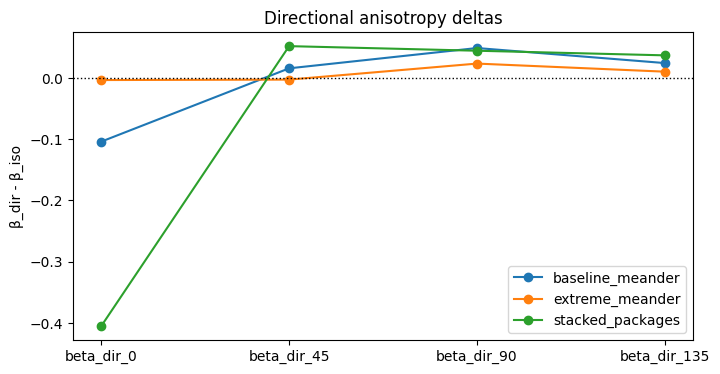

In [8]:

beta_columns = [c for c in metrics_df.columns if c.startswith("beta_dir_")]
long_df = metrics_df.melt(
    id_vars=["preset", "beta_iso"],
    value_vars=beta_columns,
    var_name="direction",
    value_name="beta_dir",
)
long_df["delta"] = long_df["beta_dir"] - long_df["beta_iso"]
fig, ax = plt.subplots(figsize=(8, 4))
for preset, subset in long_df.groupby("preset"):
    ax.plot(subset["direction"], subset["delta"], marker="o", label=preset)
ax.axhline(0.0, color="black", linewidth=1, linestyle=":")
ax.set_ylabel("β_dir - β_iso")
ax.set_title("Directional anisotropy deltas")
ax.legend()
plt.show()


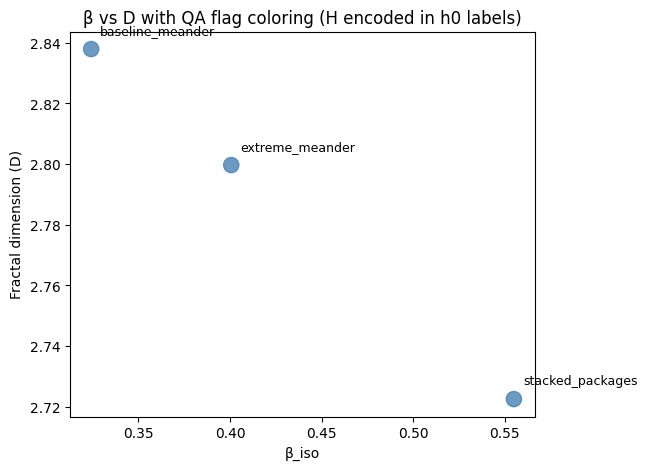

,preset,h0,qa_psd_anisotropy_warning,qa_channel_area_warning
0,baseline_meander,11.170860,False,False
1,extreme_meander,127.677243,False,False
2,stacked_packages,16.992237,False,False


In [9]:
fig, ax = plt.subplots(figsize=(6, 5))
colors = np.where(metrics_df["qa_psd_anisotropy_warning"], "orangered", "steelblue")
scatter = ax.scatter(
    metrics_df["beta_iso"],
    metrics_df["fractal_dimension"],
    c=colors,
    s=120,
    alpha=0.8,
)
for _, row in metrics_df.iterrows():
    ax.text(row["beta_iso"] + 0.005, row["fractal_dimension"] + 0.005, row["preset"], fontsize=9)
ax.set_xlabel("β_iso")
ax.set_ylabel("Fractal dimension (D)")
ax.set_title("β vs D with QA flag coloring (H encoded in h0 labels)")
plt.show()
metrics_df[["preset", "h0", "qa_psd_anisotropy_warning", "qa_channel_area_warning"]]


### Phase 1 vs Phase 2 summary
- Phase mapping: single-belt presets → Phase 1, stacked → Phase 2
- Anchors: `anchor-fluvial-metrics`, `anchor-fluvial-variogram`, `anchor-fluvial-psd-topology`
- Tables below summarize β/PSD/entropy/topology aggregates for reporting and QA review.


In [10]:

phase_group = metrics_df.groupby("phase")[
    [
        "beta_iso",
        "psd_aspect",
        "entropy_global",
        "fractal_dimension",
        "topology_channel_area_fraction",
    ]
].agg(["mean", "std"])
phase_group


beta_iso           psd_aspect           entropy_global            \
             mean       std       mean       std           mean       std   
phase                                                                       
Phase 1  0.362428  0.054087   1.033125  0.010173    -110.869660  3.830416   
Phase 2  0.555015       NaN   1.172802       NaN    -105.268632       NaN   

        fractal_dimension           topology_channel_area_fraction           
                     mean       std                           mean      std  
phase                                                                        
Phase 1          2.818786  0.027043                       0.140846  0.00014  
Phase 2          2.722492       NaN                       0.380844      NaN

### Validation notes
- Executed end-to-end to refresh PSD/variogram plots and tables.
- Validate against PRD anchors and GEOLOGIC_RULES; QA flags surfaced in tables/plots.
- Exported metrics table to `outputs/stats/fluvial-demo/fluvial_metrics_table.csv` for Task Master/reporting ingestion.


In [11]:
output_dir = Path("outputs/stats/fluvial-demo")
output_dir.mkdir(parents=True, exist_ok=True)
metrics_path = output_dir / "fluvial_metrics_table.csv"
metrics_df.to_csv(metrics_path, index=False)
print(f"Metrics exported to {metrics_path}")


Metrics exported to outputs/stats/fluvial-demo/fluvial_metrics_table.csv
